In [1]:
import time
import datetime
from tqdm.notebook import tqdm
import re
import numpy as np
import pandas as pd
import seaborn as sns; sns.set() # sns.set() ==> グラフの見た目をseabornに合わせる
from collections import Counter
from sklearn import preprocessing
import pickle

import lightgbm as lgb
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score

import optuna.integration.lightgbm as lgb_o

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
race_data = pd.read_csv('data/HorseSeiseki2021.csv')
cols = ['年',
        '月',
        '日',
        '日付S',
        '回次',
        '場所',
        '日次',
        '発走時刻',
        'レース番号',
        'レースID',
        '略レース名',
        'クラスコード',
        '芝・ダ',
        'トラックコード',
        'コーナー回数',
        '距離',
        'コース区分',
        '馬場状態',
        '天候',
        '馬名',
        '性別',
        '年齢',
        '騎手',
        '斤量',
        'ブリンカー',
        '頭数',
        '枠番',
        '馬番',
        '入先着順',
        '異常コード',
        '確定着順',
        '着差タイム',
        '人気',
        '走破タイム秒',
        'タイムS',
        '補正タイム',
        '補9',
        '通過順1角',
        '通過順2角',
        '通過順3角',
        '通過順4角',
        '脚質',
        '上がり3F',
        '馬体重',
        '増減',
        '調教師',
        '所属',
        '賞金',
        '血統登録番号',
        '騎手コード',
        '調教師コード',
        '馬主名',
        '生産者名',
        '父馬名',
        '母馬名',
        '母の父名',
        '毛色',
        '生年月日',
        '単勝オッズ',
        'PCI',
        'RPCI',
        'PCI3',
        'Ave-3F',
        'レース名',
        '年齢限定競走種別コード',
        '競走記号コード',
        '重量コード',
        '1着本賞金',
       ]
race_data.columns = cols
race_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46748 entries, 0 to 46747
Data columns (total 68 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   年            46748 non-null  int64  
 1   月            46748 non-null  int64  
 2   日            46748 non-null  int64  
 3   日付S          46748 non-null  object 
 4   回次           46748 non-null  int64  
 5   場所           46748 non-null  object 
 6   日次           46748 non-null  object 
 7   発走時刻         46748 non-null  object 
 8   レース番号        46748 non-null  int64  
 9   レースID        46748 non-null  int64  
 10  略レース名        46748 non-null  object 
 11  クラスコード       46748 non-null  int64  
 12  芝・ダ          46748 non-null  object 
 13  トラックコード      46748 non-null  int64  
 14  コーナー回数       45297 non-null  float64
 15  距離           46748 non-null  int64  
 16  コース区分        22610 non-null  object 
 17  馬場状態         46748 non-null  object 
 18  天候           46748 non-null  object 
 19  馬名  

/home/toshiya/.local/share/virtualenvs/keiba-fIgOWeR2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
race_data.head()

,年,月,日,日付S,回次,場所,日次,発走時刻,レース番号,レースID,...,単勝オッズ,PCI,RPCI,PCI3,Ave-3F,レース名,年齢限定競走種別コード,競走記号コード,重量コード,1着本賞金
0,21,6,12,2021.6.12,1,札幌,1,09:50,1,202106120101010102,...,3.7,47.7,46.8,49.27,34.1,,12,000,3,510
1,21,6,12,2021.6.12,1,札幌,1,09:50,1,202106120101010103,...,275.3,51.7,46.8,49.27,35.1,,12,000,3,510
2,21,6,12,2021.6.12,1,札幌,1,09:50,1,202106120101010104,...,57.7,44.7,46.8,49.27,34.0,,12,000,3,510
3,21,6,12,2021.6.12,1,札幌,1,09:50,1,202106120101010105,...,7.5,50.0,46.8,49.27,34.5,,12,000,3,510
4,21,6,12,2021.6.12,1,札幌,1,09:50,1,202106120101010106,...,3.9,46.6,46.8,49.27,33.8,,12,000,3,510


In [4]:
pickup = ['日付S', '年', '月', '日', '血統登録番号', '馬名', '略レース名', '場所', 'コース区分', '芝・ダ', '距離', '頭数', '入先着順', '馬場状態', '騎手コード', '騎手', '斤量', '調教師', '単勝オッズ', '人気', '補9']

race2021_1chaku = race_data.query('入先着順==1')[pickup]
race2021_1chaku

,日付S,年,月,日,血統登録番号,馬名,略レース名,場所,コース区分,芝・ダ,...,頭数,入先着順,馬場状態,騎手コード,騎手,斤量,調教師,単勝オッズ,人気,補9
7,2021.6.12,21,6,12,2018105875,ディーバサンライズ,未勝利,札幌,A,芝,...,16,1,良,1181,秋山稔樹,52.0,小林真也,13.5,7.0,87.0
15,2021.6.12,21,6,12,2018105205,ペイルライダー,未勝利・牝,札幌,NaN,ダ,...,14,1,良,666,武豊,54.0,角田晃一,2.4,1.0,85.0
39,2021.6.12,21,6,12,2018100403,エレファンティネ,未勝利,札幌,NaN,ダ,...,12,1,良,1157,鮫島克駿,54.0,斎藤誠,67.7,11.0,87.0
43,2021.6.12,21,6,12,2018100537,シルキーヴォイス,未勝利,札幌,A,芝,...,15,1,良,1182,泉谷楓真,54.0,池江泰寿,35.8,10.0,81.0
66,2021.6.12,21,6,12,2019104536,カイカノキセキ,新馬,札幌,A,芝,...,13,1,良,1157,鮫島克駿,54.0,池添学,6.3,3.0,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46698,2021.9.5,21,9,5,2017100922,フチサンメルチャン,１勝ｸﾗｽ,小倉,NaN,ダ,...,13,1,稍,894,小牧太,57.0,服部利之,26.1,8.0,91.0
46710,2021.9.5,21,9,5,2018105081,ジェラルディーナ,筑後川特･2勝,小倉,B,芝,...,11,1,良,1014,福永祐一,52.0,斉藤崇史,1.7,1.0,100.0
46723,2021.9.5,21,9,5,2017105789,メイショウダジン,西日本Ｈ･3勝,小倉,NaN,ダ,...,16,1,稍,732,幸英明,56.0,松永昌博,6.8,2.0,108.0
46735,2021.9.5,21,9,5,2019103753,ナムラクレア,小倉２歳G3,小倉,B,芝,...,10,1,良,1115,浜中俊,54.0,長谷川浩,6.4,4.0,98.0


In [5]:
# 単勝支持率を計算する(Series型で返却する)
def calc_supporter(odds):
    #print(odds)
    TANSHO_DEDUCTION = 80.0 # 単勝の控除率を引いた％

    shijiritu = np.round(TANSHO_DEDUCTION / odds.values, 2)          # numpyで計算
    return pd.Series(shijiritu, index=odds.index, name='単勝支持率')  # numpy -> Serise型へ変換
                                                                    # その際、indexとnameを指定する
    
sup = calc_supporter(race2021_1chaku['単勝オッズ'])

race2021_1chaku = race2021_1chaku.join(sup)  # DataFrame + Seriseをindexが同じだからjoinで結合できる

In [6]:
race2021_1chaku.tail(40)

,日付S,年,月,日,血統登録番号,馬名,略レース名,場所,コース区分,芝・ダ,...,入先着順,馬場状態,騎手コード,騎手,斤量,調教師,単勝オッズ,人気,補9,単勝支持率
46205,2021.8.28,21,8,28,2019109140,ヒノクニ,ひまわり,小倉,B,芝,...,1,良,1142,長岡禎仁,53.0,深山雅史,7.4,3.0,80.0,10.81
46214,2021.8.28,21,8,28,2016101958,レッドルーヴル,西海賞･2勝,小倉,B,芝,...,1,良,1160,荻野極,55.0,笹田和秀,6.2,4.0,99.0,12.90
46225,2021.8.28,21,8,28,2017102914,シンシティ,釜山Ｓ･3勝,小倉,NaN,ダ,...,1,良,1114,田中健,55.0,木原一良,6.2,3.0,105.0,12.90
46243,2021.8.28,21,8,28,2018105382,レアシャンパーニュ,１勝ｸﾗｽ,小倉,B,芝,...,1,良,1154,松若風馬,52.0,音無秀孝,3.1,1.0,92.0,25.81
46254,2021.8.29,21,8,29,2019102179,ケイティソルジャー,未勝利*,小倉,NaN,ダ,...,1,良,1152,小崎綾也,54.0,村山明,1.3,1.0,92.0,61.54
46262,2021.8.29,21,8,29,2018104558,エリカヴァレリア,未勝利,小倉,B,芝,...,1,良,1115,浜中俊,54.0,杉山晴紀,1.8,1.0,83.0,44.44
46287,2021.8.29,21,8,29,2018104095,メイプルリズム,未勝利・牝,小倉,B,芝,...,1,良,1157,鮫島克駿,54.0,橋口慎介,3.7,2.0,83.0,21.62
46296,2021.8.29,21,8,29,2018105849,メイショウキートス,未勝利,小倉,NaN,ダ,...,1,良,1141,中井裕二,54.0,中内田充,3.9,1.0,87.0,20.51
46309,2021.8.29,21,8,29,2019105546,マテンロウスカイ,新馬,小倉,B,芝,...,1,良,1019,秋山真一,54.0,松永幹夫,7.1,4.0,87.0,11.27
46326,2021.8.29,21,8,29,2019105794,ホワイトターフ,新馬,小倉,B,芝,...,1,良,1187,永島まな,50.0,新谷功一,6.3,3.0,85.0,12.70


xxxxxxxxxxxxxxxxxxxxxxxxx
5頭
(0, 2]       0
(2, 6]       0
(6, 10]      0
(10, 20]     1
(20, 50]     0
(50, 100]    2
Name: 単勝支持率, dtype: int64


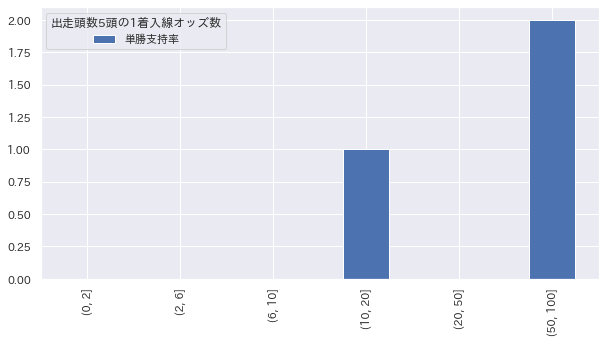

xxxxxxxxxxxxxxxxxxxxxxxxx
6頭
(0, 2]       0
(2, 6]       1
(6, 10]      1
(10, 20]     3
(20, 50]     6
(50, 100]    0
Name: 単勝支持率, dtype: int64


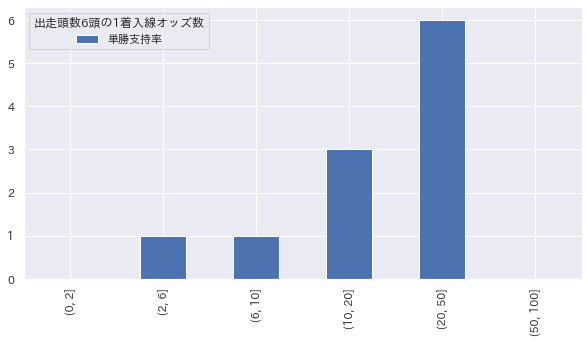

xxxxxxxxxxxxxxxxxxxxxxxxx
7頭
(0, 2]        0
(2, 6]        1
(6, 10]       4
(10, 20]      8
(20, 50]     24
(50, 100]    12
Name: 単勝支持率, dtype: int64


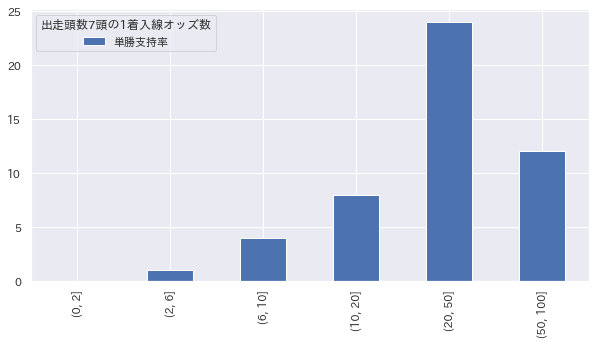

xxxxxxxxxxxxxxxxxxxxxxxxx
8頭
(0, 2]        2
(2, 6]        6
(6, 10]      10
(10, 20]     25
(20, 50]     61
(50, 100]    11
Name: 単勝支持率, dtype: int64


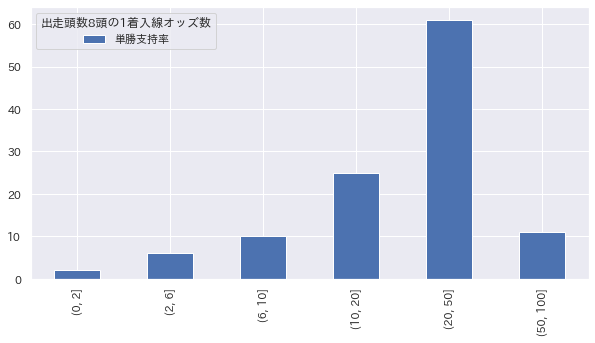

xxxxxxxxxxxxxxxxxxxxxxxxx
9頭
(0, 2]        3
(2, 6]       11
(6, 10]      13
(10, 20]     36
(20, 50]     71
(50, 100]    22
Name: 単勝支持率, dtype: int64


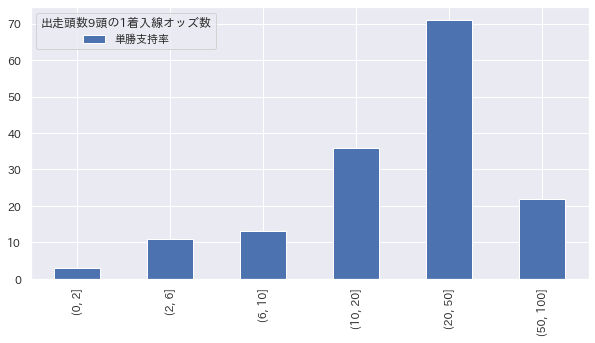

xxxxxxxxxxxxxxxxxxxxxxxxx
10頭
(0, 2]        6
(2, 6]       21
(6, 10]      22
(10, 20]     49
(20, 50]     89
(50, 100]    14
Name: 単勝支持率, dtype: int64


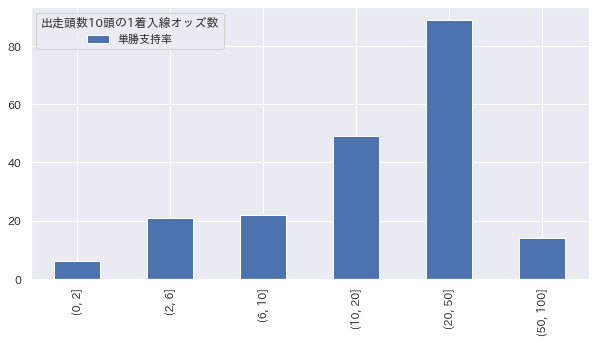

xxxxxxxxxxxxxxxxxxxxxxxxx
11頭
(0, 2]        4
(2, 6]       21
(6, 10]      20
(10, 20]     67
(20, 50]     90
(50, 100]    14
Name: 単勝支持率, dtype: int64


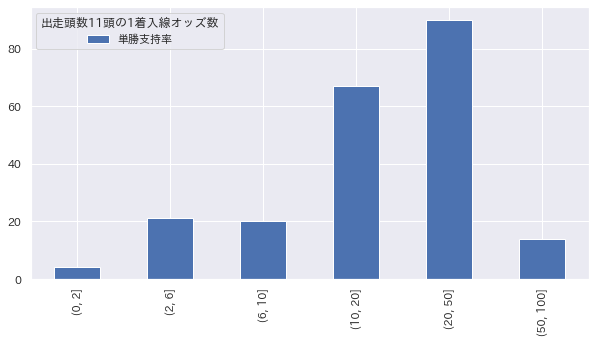

xxxxxxxxxxxxxxxxxxxxxxxxx
12頭
(0, 2]        12
(2, 6]        38
(6, 10]       32
(10, 20]      83
(20, 50]     123
(50, 100]      7
Name: 単勝支持率, dtype: int64


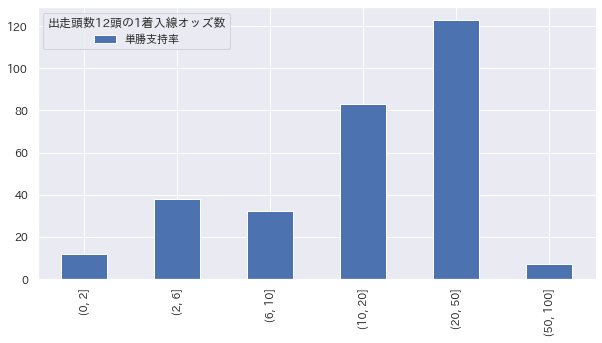

xxxxxxxxxxxxxxxxxxxxxxxxx
13頭
(0, 2]       11
(2, 6]       33
(6, 10]      35
(10, 20]     64
(20, 50]     96
(50, 100]     7
Name: 単勝支持率, dtype: int64


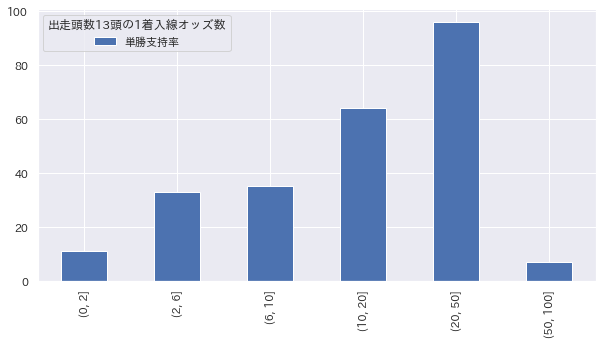

xxxxxxxxxxxxxxxxxxxxxxxxx
14頭
(0, 2]        15
(2, 6]        55
(6, 10]       44
(10, 20]     108
(20, 50]     139
(50, 100]      5
Name: 単勝支持率, dtype: int64


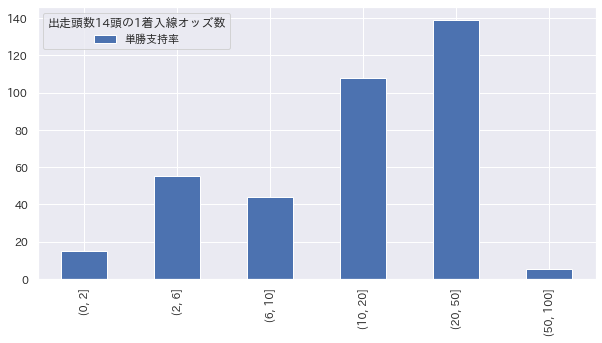

xxxxxxxxxxxxxxxxxxxxxxxxx
15頭
(0, 2]        14
(2, 6]        62
(6, 10]       56
(10, 20]     111
(20, 50]     137
(50, 100]      9
Name: 単勝支持率, dtype: int64


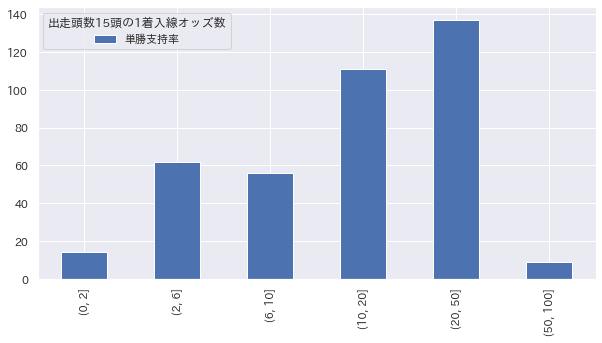

xxxxxxxxxxxxxxxxxxxxxxxxx
16頭
(0, 2]        52
(2, 6]       166
(6, 10]      150
(10, 20]     321
(20, 50]     356
(50, 100]     25
Name: 単勝支持率, dtype: int64


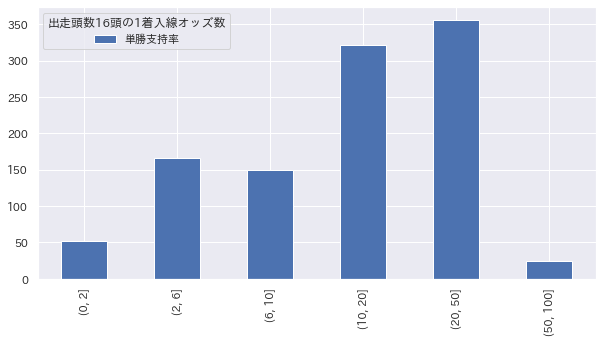

xxxxxxxxxxxxxxxxxxxxxxxxx
17頭
(0, 2]        7
(2, 6]        6
(6, 10]       8
(10, 20]     15
(20, 50]     19
(50, 100]     1
Name: 単勝支持率, dtype: int64


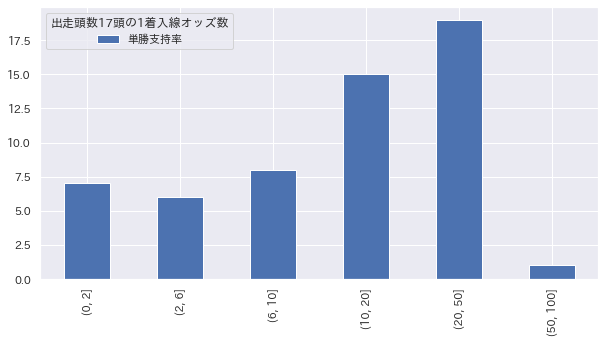

xxxxxxxxxxxxxxxxxxxxxxxxx
18頭
(0, 2]        9
(2, 6]       35
(6, 10]      36
(10, 20]     68
(20, 50]     68
(50, 100]     4
Name: 単勝支持率, dtype: int64


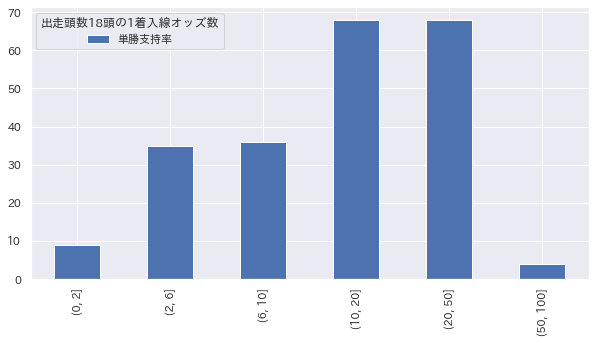

In [7]:
tosu = np.sort(race2021_1chaku['頭数'].unique()) # -> array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
for t in tosu:
    race2021_group = race2021_1chaku.groupby('頭数')
    #tan_shiji_bining = pd.cut(race2021_group.get_group(t)['単勝支持率'], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 100])
    tan_shiji_bining = pd.cut(race2021_group.get_group(t)['単勝支持率'], [0, 2, 6, 10, 20, 50, 100])
    print('xxxxxxxxxxxxxxxxxxxxxxxxx')
    print(f'{t}頭')
    print(tan_shiji_bining.value_counts().sort_index())
    
    coco = pd.DataFrame(tan_shiji_bining.value_counts().sort_index())
    #print('{}頭 {:.3f}'.format(t, race2021_group.get_group(t)['単勝オッズ'].agg('mean')))
    sns.set(rc = {'figure.figsize':(10, 5)})
    coco.plot.bar()
    #cross_tyaku.plot.bar()
    title = '出走頭数{}頭の1着入線オッズ数'.format(t)
    plt.legend(title=title)
    plt.show()

---------------------------
5頭


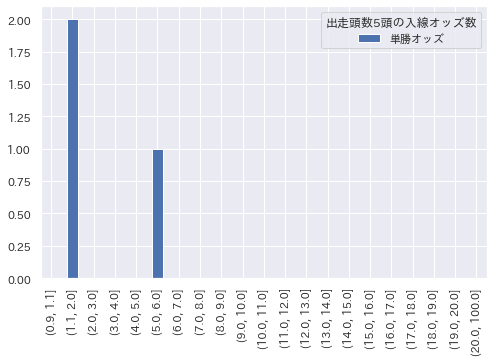

---------------------------
6頭


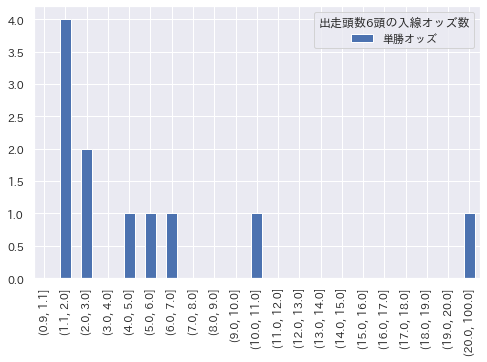

---------------------------
7頭


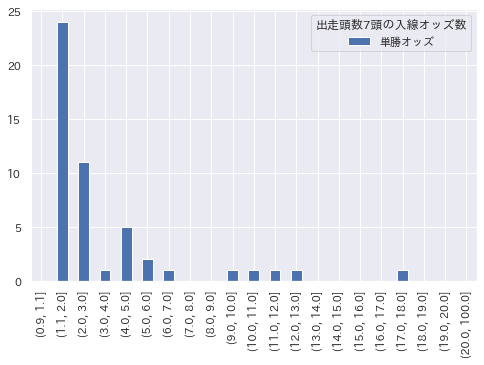

---------------------------
8頭


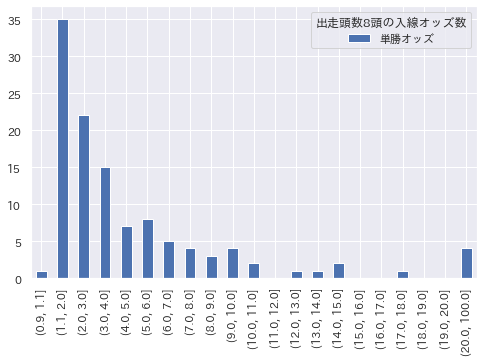

---------------------------
9頭


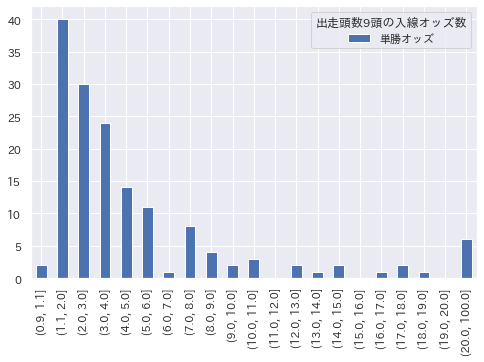

---------------------------
10頭


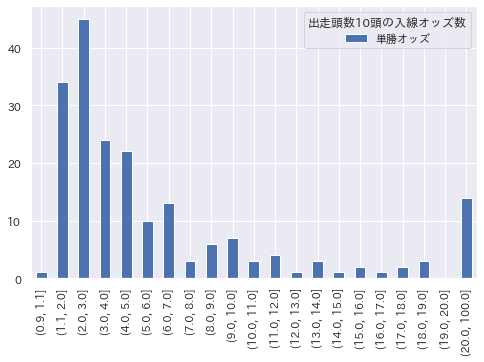

---------------------------
11頭


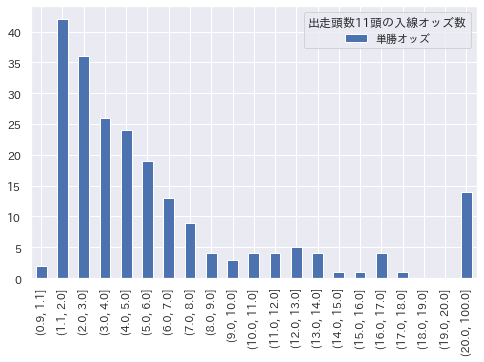

---------------------------
12頭


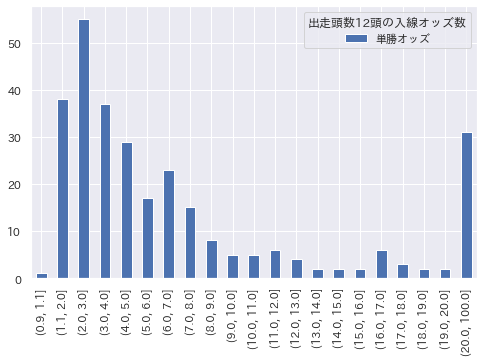

---------------------------
13頭


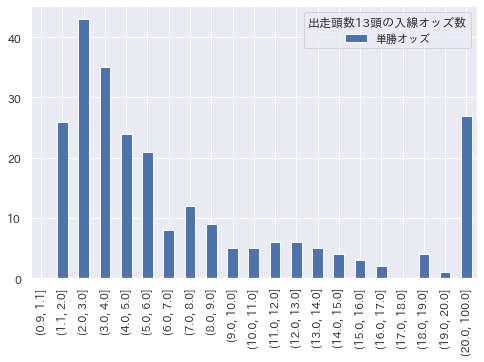

---------------------------
14頭


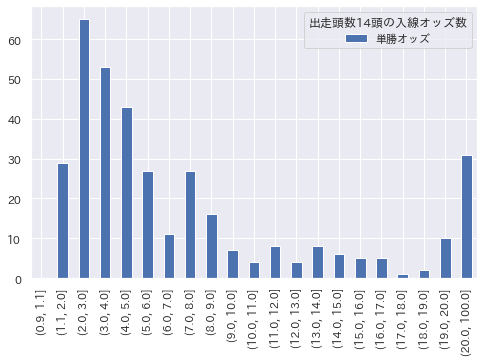

---------------------------
15頭


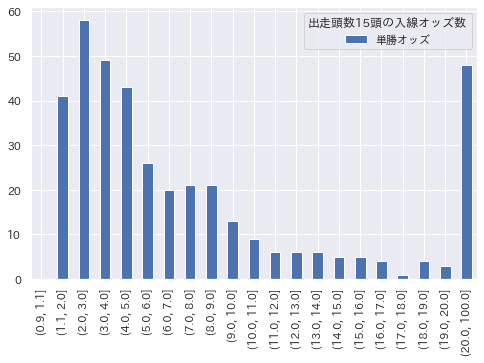

---------------------------
16頭


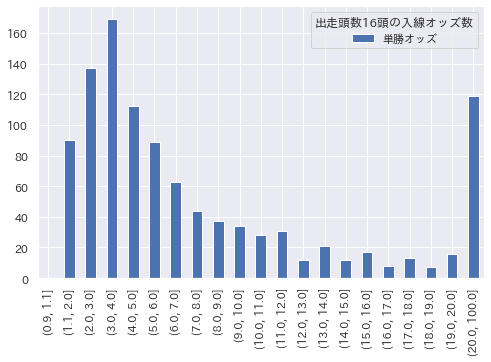

---------------------------
17頭


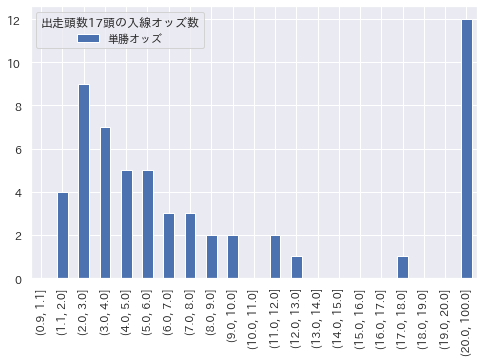

---------------------------
18頭


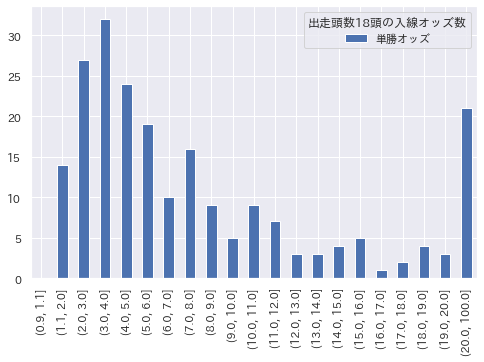

In [8]:
tosu = np.sort(race2021_1chaku['頭数'].unique()) # -> array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
for t in tosu:
    race2021_group = race2021_1chaku.groupby('頭数')
#    tan_odds_bining = pd.cut(race2021_group.get_group(t)['単勝オッズ'], [.99, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 30, 50, 100, 1000],
#                             labels=['1..2.5', '2.5..5', '5..7.5', '7.5..10', '10..12.5', '12.5..15', '15..17.5', '17.5..20', '20..30', '30..50', '50..100', '万'])
    tan_odds_bining = pd.cut(race2021_group.get_group(t)['単勝オッズ'], [.9, 1.1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12,13,14,15,16,17,18,19,20, 100])
    print('---------------------------')
    #print(race2021_group.get_group(t)[['単勝オッズ', '入先着順']])
    print(f'{t}頭')
    #print(tan_odds_bining.value_counts().sort_index())
    coco = pd.DataFrame(tan_odds_bining.value_counts().sort_index())
    #print('{}頭 {:.3f}'.format(t, race2021_group.get_group(t)['単勝オッズ'].agg('mean')))
    sns.set(rc = {'figure.figsize':(8,5)})
    coco.plot.bar()
    #cross_tyaku.plot.bar()
    title = '出走頭数{}頭の入線オッズ数'.format(t)
    plt.legend(title=title)
    plt.show()

In [9]:
race2021_1chaku.query('頭数==6')[['', ]]

KeyError: "None of [Index([''], dtype='object')] are in the [columns]"

In [9]:
race2021_group.get_group(10)

,年,月,日,日付S,回次,場所,日次,発走時刻,レース番号,レースID,...,単勝オッズ,PCI,RPCI,PCI3,Ave-3F,レース名,年齢限定競走種別コード,競走記号コード,重量コード,1着本賞金
95,21,6,12,2021.6.12,1,札幌,1,13:45,8,202106120101010801,...,35.0,48.9,51.8,53.2,36.39,,13,A00,4,760
96,21,6,12,2021.6.12,1,札幌,1,13:45,8,202106120101010802,...,15.2,49.5,51.8,53.2,36.21,,13,A00,4,760
97,21,6,12,2021.6.12,1,札幌,1,13:45,8,202106120101010803,...,4.8,53.5,51.8,53.2,36.21,,13,A00,4,760
98,21,6,12,2021.6.12,1,札幌,1,13:45,8,202106120101010804,...,4.0,54.3,51.8,53.2,36.39,,13,A00,4,760
99,21,6,12,2021.6.12,1,札幌,1,13:45,8,202106120101010805,...,13.3,52.8,51.8,53.2,36.30,,13,A00,4,760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41980,21,9,5,2021.9.5,4,小倉,8,15:35,11,202109051004081106,...,114.3,46.3,48.0,50.1,34.00,小倉２歳Ｓ,11,N04,3,3100
41981,21,9,5,2021.9.5,4,小倉,8,15:35,11,202109051004081107,...,6.2,49.7,48.0,50.1,34.10,小倉２歳Ｓ,11,N04,3,3100
41982,21,9,5,2021.9.5,4,小倉,8,15:35,11,202109051004081108,...,16.7,47.1,48.0,50.1,33.90,小倉２歳Ｓ,11,N04,3,3100
41983,21,9,5,2021.9.5,4,小倉,8,15:35,11,202109051004081109,...,6.4,50.3,48.0,50.1,34.00,小倉２歳Ｓ,11,N04,3,3100
